# Problem Statement:
## Task 2

The bit-flip code and the sign-flip code (you can find a description of both [here](https://en.wikipedia.org/wiki/Quantum_error_correction)) are two very simple circuits able to detect and fix the bit-flip and the sign-flip errors, respectively.

1. Build the following simple circuit to prepare the Bell state:

![Bell State generating circuit](bell-circuit.png)

2. Now add, right before the CNOT gate and for each of the two qubits, an arbitrary "error gate". By error gate, we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a 1-qubit unitary which can be either the identity, or the $X$ gate (bit-flip error) or the $Z$ gate (sign-flip error).
3. Encode each of the two qubits with a sign-flip or bit-flip code, in such a way that **all the possible** choices for the error gates described in (2), occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!
4. Test your solution by making measurements over the final state and testing that the results are in line with the expectation.


In [139]:
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram

from matplotlib import pyplot as plt

%matplotlib inline

import numpy as np

sv_sim = Aer.get_backend('statevector_simulator')
qasm_sum = Aer.get_backend('qasm_simulator')

### 1. Circuit with no errors

In [140]:
qc_1 = QuantumCircuit(2)    # Create the quantum circuit object with 2 qubits
qc_1.h(0)                   # Add a Hadamard gate on the first qubit
qc_1.cx(0,1)                # Add a CNOT gate with first qubit as control and second as target

qc_1.draw()                 # Display the circuit

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

#### Running Circuit 1

With no errors, this circuit should produce the Bell state:
$$ |\beta_{00}\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}} $$

Upon measuring this state, we should observe these statistics:

|**Measured State**|**Probability**|
|:----------------:|--------------:|
|00|0.5|
|01|0.0|
|10|0.0|
|11|0.5|

Output state vector:  [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


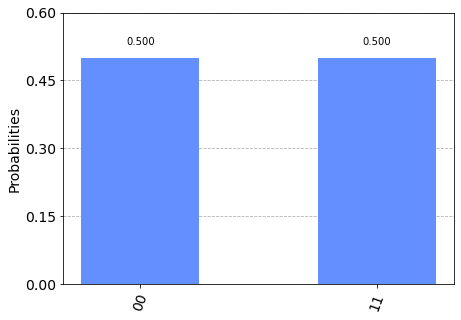

In [141]:
result = execute(qc_1,sv_sim).result()
print('Output state vector: ', result.get_statevector())

counts = result.get_counts()
plot_histogram(counts)

### 2. Circuit prone to errors, without error correction

Now, each qubit is subject to a random error before the CNOT gate. For each qubit the probability of encountering an $X$ error is $p$, the probability of encountering a $Z$ error is $p$ and thus, the probability of no error is $1-2p$.

You can adjust the value of p in the cell below:

In [142]:
p=0.3

The next cell defines a function that will add a random error gate the circuit.

* `qubit`: The index of the qubit to add the error gate to
* `prob`: The probability of the error gates occuring (assumes every error is equally likely)
* `error_gates`: A list of possible error gates (pass in the form `[quantumCircuit.gate0, ...]`)

In [143]:
def addDiscreteErrorGate(qubit, prob, error_gates):
    n = len(error_gates)
    
    # Check to make sure n*prob<=1
    if(n*prob > 1):
        raise ValueError('The entered probability is invalid, {}*prob > 1'.format(n))
    
    rand = np.random.uniform(0,1)
    #print(rand) # Debugging line
    
    # Apply error_gate[i] if the randomly generated number is between i*prob and (i+1)*prob
    for i in range(n):
        if rand < (i+1)*prob:
            error_gates[i](qubit)
            return
    

The next cell defines a circuit that implements this random error.

In [144]:
def genCircuit2(prob):
    qc = QuantumCircuit(2)
    qc.h(0)

    addDiscreteErrorGate(0,prob,[qc.x, qc.z])
    addDiscreteErrorGate(1,prob,[qc.x, qc.z])

    qc.cx(0,1)
    
    return qc

qc_2=genCircuit2(p)
qc_2.draw()

┌───┐┌───┐     
q_0: ┤ H ├┤ X ├──■──
     ├───┤└───┘┌─┴─┐
q_1: ┤ Z ├─────┤ X ├
     └───┘     └───┘

Output state vector:  [ 0.70710678+0.j -0.        +0.j -0.        +0.j  0.70710678+0.j]


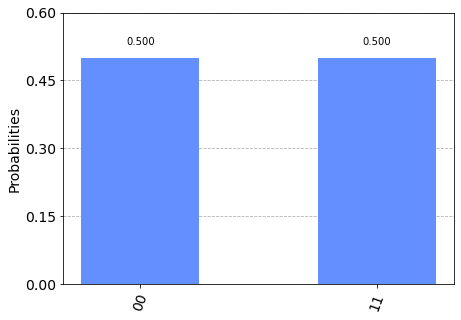

In [145]:
result = execute(qc_2,sv_sim).result()
print('Output state vector: ', result.get_statevector())

counts = result.get_counts()
plot_histogram(counts)

#### Running Circuit 2

In the above cell I displayed the output state and measurement statistics of **one instance** of Circuit 2. Since there are multiple possible ways in which the error can manifest in this circuit, it would make more sense to look at the fidelity of the circuit.

Fidelity is a measure of "how close" two quantum states are. For the pure state $|\psi\rangle$, that is the output of the error-prone circuit, and $|\phi\rangle$ that is the output of the error-free circuit, the fidelity is calculated as:
$$ F = |\langle \psi | \phi \rangle |^2 $$

We can measure the average fidelity by doing the above calculation for multiple instances of Circuit 2.

In [146]:
N = 250 # Number of trials

phi = np.array([(1.0+0.0j)/np.sqrt(2),0.0j,0.0j,(1.0+0.0j)/np.sqrt(2)])

probs = np.linspace(0,0.5,20)

F = []

for prob in probs:
    fidelities = []
    for i in range(N):
        circ = genCircuit2(prob)
        psi = execute(circ,sv_sim).result().get_statevector()
    
        fidelities.append(np.abs(np.vdot(psi,phi))**2)
    F.append(np.average(fidelities))

Given that they occur immediately after the Hadamard gate, the $X$ and $Z$ errors can only map the output onto one of the Bell states. The inner product $\langle\phi|\psi\rangle = 1$ if $|\psi\rangle=|\beta_{00}$, and 0 otherwise.

The errors that don't alter the output are: $(I,I),(I,Z),(X,I),(X,X)$ and so the expected fidelity for Circuit 2 can be calculated:
$$ F = (1-2p)^2 + (1-2p)p + p(1-2p) + p^2 = 1 - 2p + p^2 $$

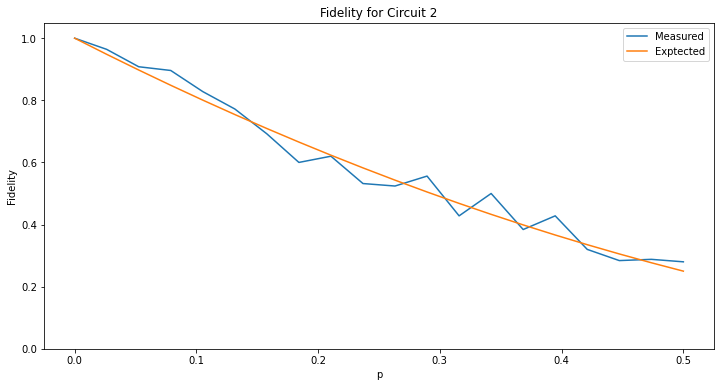

In [176]:
expected = 1 - 2*probs + probs**2 

fig = plt.figure(figsize=(12,6))

plt.title('Fidelity for Circuit 2')

plt.plot(probs,F,label='Measured')
plt.plot(probs,expected,label='Exptected')

plt.xlabel('p')
plt.ylabel('Fidelity')

plt.ylim([0,1.05])

plt.legend()

### 3. Circuit prone to errors, with error correction

